These experiments are part of a research project aimed at developing efficient methods for identifying objective masks for coronal loops, which can be used to train deep learning models. Human annotation can be subjective, time-consuming, and prone to errors, which can lead to inconsistencies in the labeling process. Additionally, the complexity of coronal loops and the variability in solar images can make it challenging for humans to accurately identify them.
By developing automated methods for generating objective masks, we can reduce the reliance on human annotation and improve the accuracy and efficiency of the process. Deep learning models, in particular, can learn to recognize patterns in solar images and segment coronal loops with high accuracy, once trained on a large dataset of labeled examples. 
"objective masks" mean binary images where pixels corresponding to coronal loops are labeled as 1 (or true) and pixels corresponding to the background are labeled as 0 (or false). These masks can be used as ground truth for training deep learning models to segment coronal loops from solar images.


In [95]:
import sunpy.map
from skimage import data
from skimage import color
from skimage.filters import hessian, gaussian, meijering
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.io import fits
from scipy.optimize import curve_fit

import sunkit_image.trace as trace


In [96]:
solar_map = sunpy.map.Map('/Users/synergy/Documents/Research/AstroPySunPy/Sample Analysis/Data/Loop/subimg23.fits')


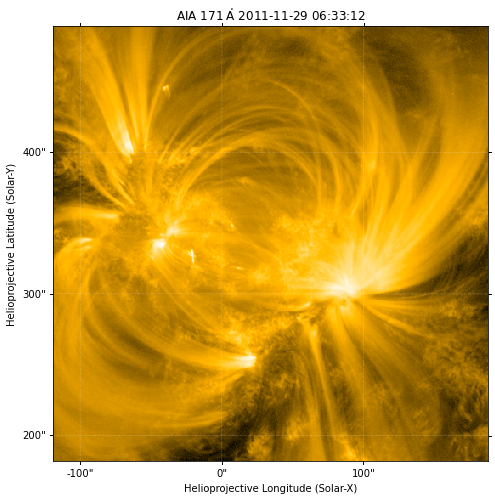

In [5]:
plt.figure(figsize=(8, 8))
solar_map.plot()
plt.show()


In [7]:
def plot_img(image, title='Loop'):
    
    global solar_map
    # Plot the filtered image
    #original_map = sunpy.map.Map(solar_map, solar_map.meta)
    processed_map = sunpy.map.Map(image, solar_map.meta)
    plt.figure(figsize=(8, 8))
    processed_map.plot()
    plt.title(title)
    plt.axis('off')
    plt.show()
    return processed_map

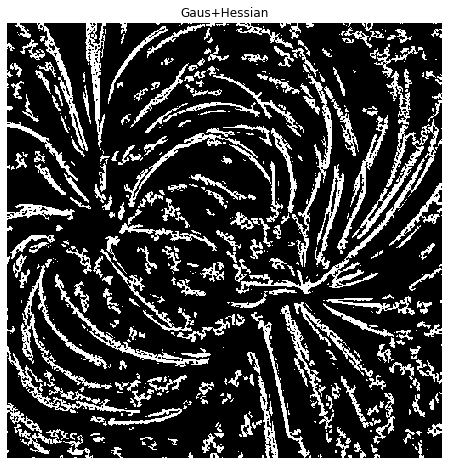

In [253]:
image_g = gaussian(solar_map.data, sigma=[.1,.1])
image_gh = hessian(image_g, sigmas=[1, 1, 2,2, 3, 3, 6, 6] )
map_gh=plot_img(image_gh, 'Gaus+Hessian')

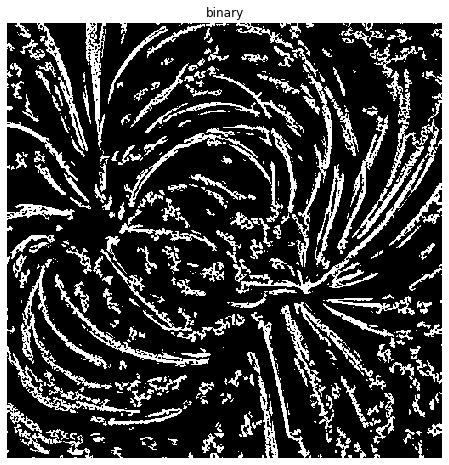

In [229]:
binary_=plot_img(np.round(map_gh.data), 'binary')


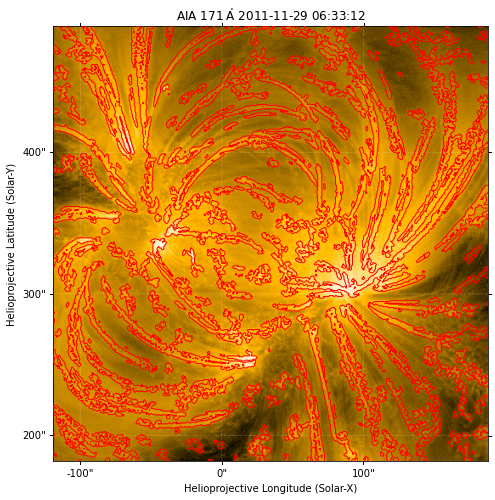

In [246]:
from skimage import measure

# Extract contours from the binary image
Contours = measure.find_contours(solar_map.data*map_gh.data, 0.1)

# Plot the solar map
plt.figure(figsize=(8,8))
solar_map.plot()


for contour in Contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')  # Assuming y-axis is the first axis and x-axis is the second axis

# Show the plot
plt.show()

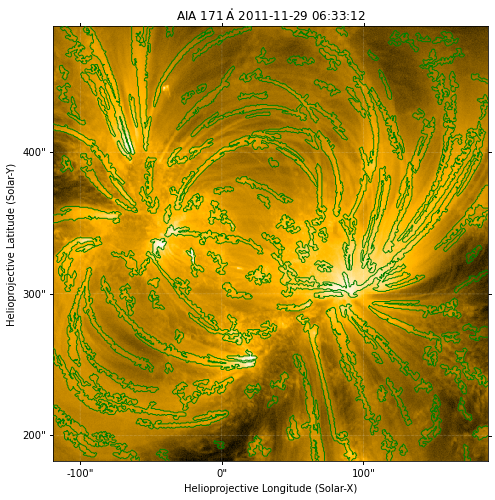

In [243]:
plt.figure(figsize=(8,8))
solar_map.plot()
# Plot contours as smooth lines over the solar map
for contourb in Contours_bin:
    if contourb.shape[0]>50:
        plt.plot(contourb[:, 1], contourb[:, 0], linewidth=1, color='green')  # Assuming y-axis is the first axis and x-axis is the second axis
# Show the plot
plt.show()

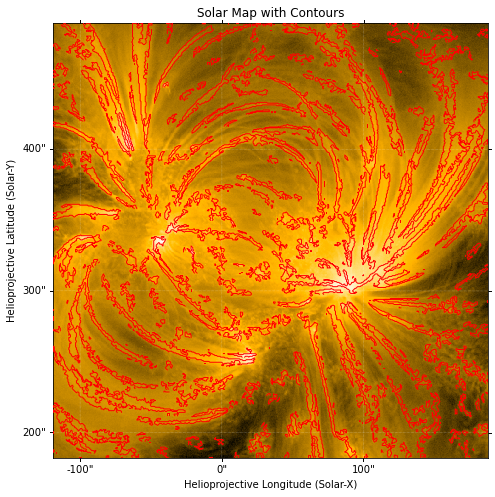

In [262]:
import sunpy.map
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load the solar map using SunPy
solar_map = sunpy.map.Map('/Users/synergy/Documents/Research/AstroPySunPy/Sample Analysis/Data/Loop/subimg23.fits')

# Assuming you have defined the functions 'gaussian' and 'hessian' to process the solar map data
image_g = gaussian(solar_map.data, sigma=[0.1, 0.1])
image_gh = hessian(image_g, sigmas=[1, 1, 2, 2, 3, 3, 6, 6])

# Convert the processed image to a suitable format for contour detection
# Threshold the image to create a binary mask
threshold_value = np.mean(image_gh)  # Adjust threshold value as needed
binary_image = (image_gh > threshold_value).astype(np.uint8) * 255

# Compute contours using OpenCV
contours_cv, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Plot the solar map with detected contours
plt.figure(figsize=(8, 8))
solar_map.plot()
plt.title('Solar Map with Contours')

for contour in contours_cv:
    # Plot each contour
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], 'r', linewidth=1)

plt.show()


In [267]:
def is_v_shape(contour):
    # Fit a line to the contour using the endpoints
    if len(contour) < 3:
        return False, None, None
    
    x1, y1 = contour[0][0]
    x2, y2 = contour[-1][0]
    
    # Calculate the slope of the line between endpoints
    if x2 - x1 != 0:
        slope = (y2 - y1) / (x2 - x1)
    else:
        slope = np.inf  # Vertical line (undefined slope)
    
    # Check if the contour resembles a "V shape"
    if abs(slope) > 1.0:  # Adjust slope threshold based on angle of "V"
        return True, (x1, y1), (x2, y2)
    else:
        return False, None, None


In [272]:
def is_v_shape(contour):
    # Fit a line to the contour using the endpoints
    if len(contour) < 3:
        return False, None, None
    
    x1, y1 = contour[0][0]
    x2, y2 = contour[-1][0]
    
    # Calculate the slope of the line between endpoints
    if x2 - x1 != 0:
        slope = (y2 - y1) / (x2 - x1)
    else:
        slope = np.inf  # Vertical line (undefined slope)
    
    # Check if the contour resembles a "V shape"
    if abs(slope) > 1.0:  # Adjust slope threshold based on angle of "V"
        return True, (x1, y1), (x2, y2)
    else:
        return False, None, None

# List to store detected V shapes
detected_v_shapes = []

# Iterate over contours and detect V shapes
for contour in contours:
    is_v, endpoints1, endpoints2 = is_v_shape(contour)
    
    if is_v:
        # Unpack endpoints if not None
        if endpoints1 is not None and endpoints2 is not None:
            x1, y1 = endpoints1
            x2, y2 = endpoints2
            
            # Draw a line between the endpoints of the V shape
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Store the endpoints of the V shape
            detected_v_shapes.append((x1, y1, x2, y2))



In [ ]:
contours=Contours
# Define a new list to store filtered contours
filtered_contours = []

# Iterate over contours
for contour in contours:
    x = contour[:, 1]  # Assuming x-coordinates are in the second column
    y = contour[:, 0]

    # Calculate the range of x and y coordinates
    x_range = np.abs(x.max() - x.min())
    y_range = np.abs(y.max() - y.min())

    # Check conditions for filtering (change the threshold values as needed)
    if x_range > 20 or y_range > 20:
        # Contour meets the criteria, add to filtered list
        filtered_contours.append(contour)

# Update the original list with the filtered contours
contours = filtered_contours

In [208]:
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

In [215]:
fitted_curves = []

for contour in contours:
    # Extract x and y coordinates of the contour
    x = contour[:, 1]  # Assuming x-coordinates are in the second column
    y = contour[:, 0]  # Assuming y-coordinates are in the first column

    # Fit a quadratic curve (a*x^2 + b*x + c) to the contour points
    popt, _ = curve_fit(quadratic_func, x, y)

    # Append the fitted curve parameters (a, b, c) to the list
    fitted_curves.append(popt)

<Figure size 432x288 with 0 Axes>

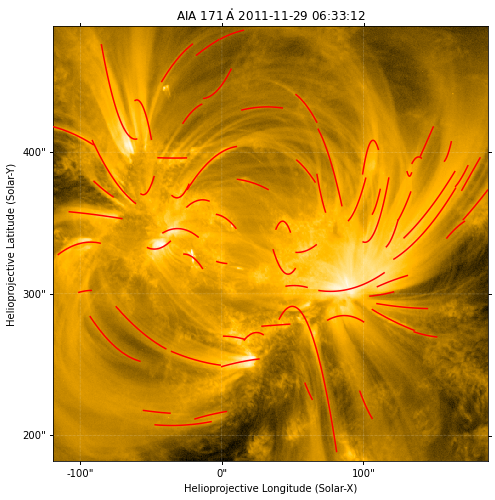

In [216]:
import matplotlib.pyplot as plt

# Plot original contours and fitted quadratic curves
plt.figure()
plt.figure(figsize=(8,8))
solar_map.plot()
for contour, popt in zip(contours, fitted_curves):
    x = contour[:, 1]
    y = contour[:, 0]
    #plt.plot(x, y, 'b')  # Plot original contour in blue
    

    # Generate x values for the fitted quadratic curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = quadratic_func(x_fit, *popt)  # Evaluate fitted quadratic curve

    plt.plot(x_fit, y_fit, 'r-')  # Plot fitted curve in red dashed lines

plt.show()

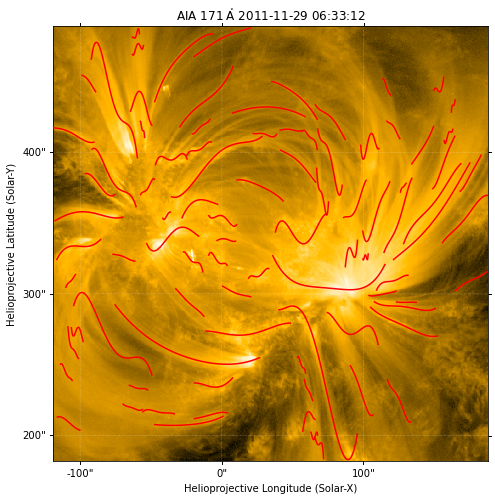

In [212]:
import numpy as np
import matplotlib.pyplot as plt

fitted_curves = []

for contour in contours:
    # Extract x and y coordinates of the contour
    x = contour[:, 1]  # Assuming x-coordinates are in the second column
    y = contour[:, 0]  # Assuming y-coordinates are in the first column

    # Fit a quadratic curve (second-degree polynomial) to the contour points
    popt = np.polyfit(x, y, 4)  # Fit a quadratic polynomial (degree=2) to (x, y) data

    # Append the fitted curve parameters (a, b, c) to the list
    fitted_curves.append(popt)

# Plot original contours and fitted quadratic curves
plt.figure(figsize=(8, 8))
solar_map.plot()
for contour, popt in zip(contours, fitted_curves):
    x = contour[:, 1]
    y = contour[:, 0]

    # Generate x values for the fitted quadratic curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = np.poly1d(popt)(x_fit)  # Evaluate fitted quadratic curve using the polynomial function

    plt.plot(x_fit, y_fit, 'r-')  # Plot fitted curve in red dashed lines

plt.show()


# Different

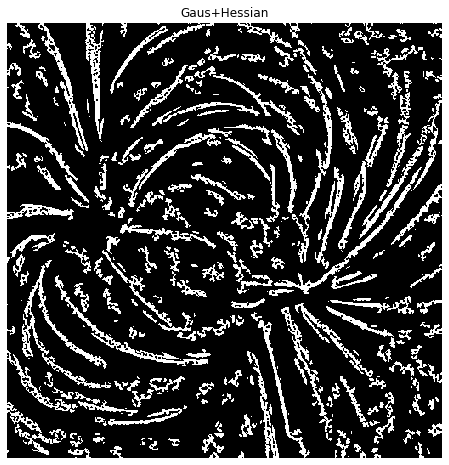

In [267]:
map_gh=plot_img(hessian(gaussian(solar_map.data, sigma=(.2, 0.2))*image_gh), 'Gaus+Hessian')

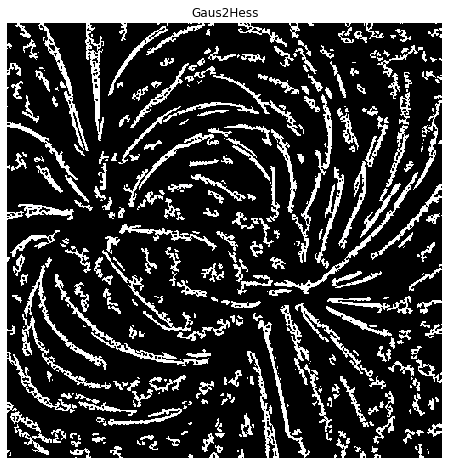

In [72]:
new_map=plot_img(hessian(hessian(image_gh)), 'Gaus2Hess')

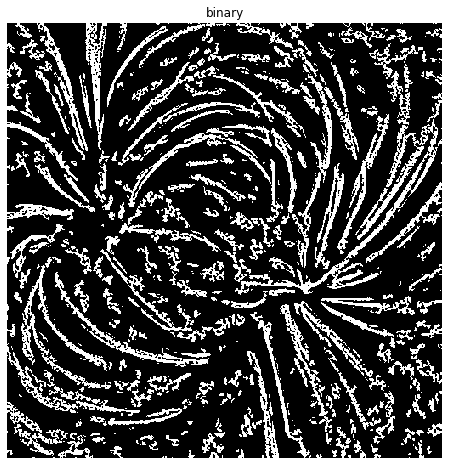

In [272]:
binary_=plot_img(np.round(map_gh.data), 'binary')


In [253]:
contours=Contours[:]


In [163]:
# List to store mean curves
mean_curves=[]
i=-1
# Process each contour
for contour in contours[:3]:
    # Extract x and y coordinates from the contour matrix
    x_coords = contour[:, 0]
    y_coords = contour[:, 1]
    # Calculate unique x-coordinates and their corresponding indices
    unique_x= np.unique(x_coords, return_inverse=False)
    print('next contour \n', contour, '\n unique x=', unique_x)
    for xx in unique_x:
        print('for unique x=', xx)
        same_x= x_coords==xx
        print('same_x', same_x,'\n')
        y_coords[same_x]=y_coords[same_x].mean()
        print('y_coords_samexx', y_coords[same_x])
    mean_curve=np.column_stack([x_coords, y_coords])
    print('\n new curve', new_curve, '\n initial curve', contour)    
    #mean_curves.append()
    #print('mean', mean_curve)
    print('--------------------')

    


   
    


next contour 
 [[ 0.  80.5]
 [ 0.5 80.5]
 [ 0.5 80.5]
 [ 0.  80.5]] 
 unique x= [0.  0.5]
for unique x= 0.0
same_x [ True False False  True] 

y_coords_samexx [80.5 80.5]
for unique x= 0.5
same_x [False  True  True False] 

y_coords_samexx [80.5 80.5]

 new curve [[ 0.  80.5]
 [ 0.5 80.5]
 [ 0.5 80.5]
 [ 0.  80.5]] 
 initial curve [[ 0.  80.5]
 [ 0.5 80.5]
 [ 0.5 80.5]
 [ 0.  80.5]]
--------------------
next contour 
 [[ 0.  83. ]
 [ 0.5 83. ]
 [ 0.  83. ]] 
 unique x= [0.  0.5]
for unique x= 0.0
same_x [ True False  True] 

y_coords_samexx [83. 83.]
for unique x= 0.5
same_x [False  True False] 

y_coords_samexx [83.]

 new curve [[ 0.  80.5]
 [ 0.5 80.5]
 [ 0.5 80.5]
 [ 0.  80.5]] 
 initial curve [[ 0.  83. ]
 [ 0.5 83. ]
 [ 0.  83. ]]
--------------------
next contour 
 [[ 0.         95.5       ]
 [ 1.         96.25      ]
 [ 1.5        98.        ]
 [ 1.         96.25      ]
 [ 0.5        97.        ]
 [ 1.         96.25      ]
 [ 2.         94.5       ]
 [ 3.         86.16666667]
 

In [ ]:
# List to store mean curves
mean_curves = []

# Process each contour
for contour in contours:
    # Make a copy of the contour array to avoid modifying the original
    contour_copy = np.copy(contour)

    # Extract x and y coordinates from the contour matrix
    x_coords = contour_copy[:, 0]
    y_coords = contour_copy[:, 1]

    # Calculate unique x-coordinates and their corresponding indices
    unique_x = np.unique(x_coords)
    
    # Calculate mean y-values for each unique x-coordinate
    for xx in unique_x:
        same_x = (x_coords == xx)
        
        # Calculate mean y-value for points with the same x-coordinate
        mean_y = np.mean(y_coords[same_x])
      
        # Replace y-values with mean_y for points with the same x-coordinate
        y_coords[same_x] = mean_y

    # Create a mean curve by stacking x_coords and updated y_coords
    mean_curve = np.unique(np.column_stack([x_coords, y_coords]), axis=0, return_index=False)
    print('Mean Curve:\n', mean_curve)

    # Append the mean curve to the list of mean curves
    mean_curves.append(mean_curve)

    # Display separator for clarity
    print('mean_curves', mean_curves, '\n --------------------')

In [74]:
from skimage import io, restoration

# Quadratic fitting approach

In [249]:
len(contours)

171

<Figure size 432x288 with 0 Axes>

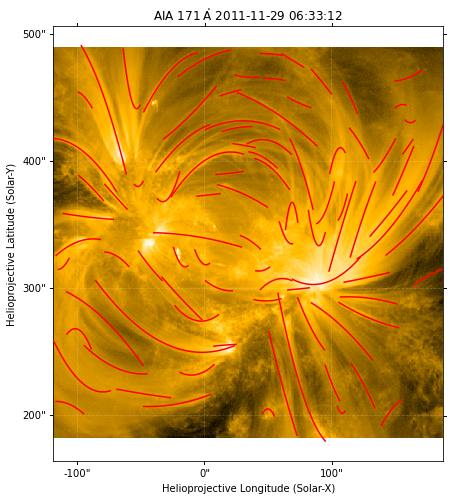

In [257]:
import matplotlib.pyplot as plt

# Plot original contours and fitted quadratic curves
plt.figure()
plt.figure(figsize=(8,8))
solar_map.plot()
for contour, popt in zip(contours, fitted_curves):
    x = contour[:, 1]
    y = contour[:, 0]
    #plt.plot(x, y, 'b')  # Plot original contour in blue
    

    # Generate x values for the fitted quadratic curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = quadratic_func(x_fit, *popt)  # Evaluate fitted quadratic curve

    plt.plot(x_fit, y_fit, 'r-')  # Plot fitted curve in red dashed lines

plt.show()


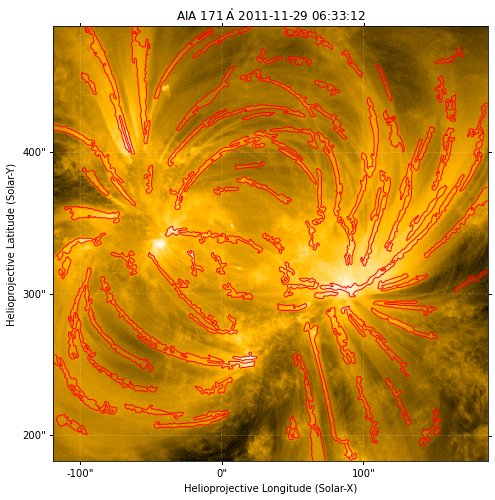

In [258]:
from skimage import measure

# Extract contours from the binary image
Contours = measure.find_contours(binary_.data, 0.5)

# Plot the solar map
plt.figure(figsize=(8,8))
solar_map.plot()

# Plot contours as smooth lines over the solar map
for contour in contours:
    plt.plot(gaussian(contour[:, 1]), gaussian(contour[:, 0]), linewidth=1, color='red')  # Assuming y-axis is the first axis and x-axis is the second axis

# Show the plot
plt.show()

In [ ]:
image_data = np.round(new_map[0].data)  # Assuming new_map is a 2D image array

# Threshold the image to obtain a binary representation
binary_image = np.where(image_data > np.mean(image_data), 1, 0)

# Find contours in the binary image
contours = measure.find_contours(binary_image, 0.5)

# Calculate mean curves from detected contours
mean_curves = []
for contour in contours:
    # Calculate mean coordinates along the contour
    mean_x = np.mean(contour[:, 1])  # Mean of x-coordinates
    mean_y = np.mean(contour[:, 0])  # Mean of y-coordinates
    mean_curve = np.array([mean_y, mean_x])  # Create mean curve point
    mean_curves.append(mean_curve)

# Create a plot of the original image with mean curves overlaid
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray')

# Plot mean curves as lines on the image
for mean_curve in mean_curves:
    plt.plot(mean_curve[1], mean_curve[0], 'r-', linewidth=2)

plt.title('Original Image with Mean Curves')
plt.axis('off')
plt.show()

In [76]:
import sunkit_image.trace as trace


In [77]:
loops = trace.occult2(img_binary.data, nsm1=3, rmin=40, lmin=25, nstruc=1000, ngap=0, qthresh1=0.1, qthresh2=3.0)


In [59]:
loopgh = trace.occult2(map_gh.data, nsm1=3, rmin=40, lmin=25, nstruc=1000, ngap=1, qthresh1=0.1, qthresh2=3.0)
loopsh = trace.occult2(new_map.data, nsm1=3, rmin=30, lmin=25, nstruc=1000, ngap=0, qthresh1=0.1, qthresh2=3.0)


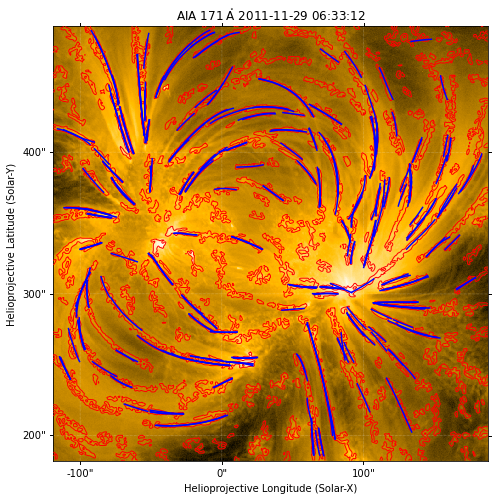

In [93]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=solar_map)
solar_map.plot()
# We can now plot each loop in the list of loops. We plot these in world coordinates, converting them
# through the `pixel_to_world` functionality which converts the pixel coordinates to coordinates (in arcsec)
# on the `trace_map`
# Plot contours as smooth lines over the solar map
for contour in contours:
    plt.plot(gaussian(contour[:, 1]), gaussian(contour[:, 0]), linewidth=1, color='red')  # Assuming y-axis is the first axis and x-axis is the second axis

for loop in loops:
    loop = np.array(loop)  # convert to array as easier to index `x` and `y` coordinates
    coord_loops = solar_map.pixel_to_world(loop[:, 0] * u.pixel, loop[:, 1] * u.pixel)
    ax.plot_coord(coord_loops, color="b")
    
for loop in loopsh:
    loop = np.array(loop)  # convert to array as easier to index `x` and `y` coordinates
    coord_loops = solar_map.pixel_to_world(loop[:, 0] * u.pixel, loop[:, 1] * u.pixel)
    ax.plot_coord(coord_loops, color="b")

for loop in loopgh:
    loop = np.array(loop)  # convert to array as easier to index `x` and `y` coordinates
    coord_loops = solar_map.pixel_to_world(loop[:, 0] * u.pixel, loop[:, 1] * u.pixel)
    ax.plot_coord(coord_loops, color="b")

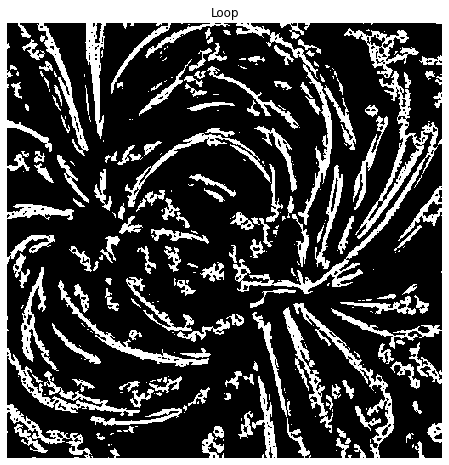

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2011-11-29 06:33:12
Exposure Time,1.999615 s
Dimension,[512. 512.] pix
Coordinate System,helioprojective
Scale,[0.599489 0.599489] arcsec / pix
Reference Pixel,[ 198.030029 -304.390015] pix

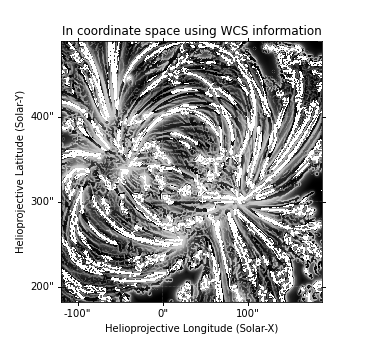
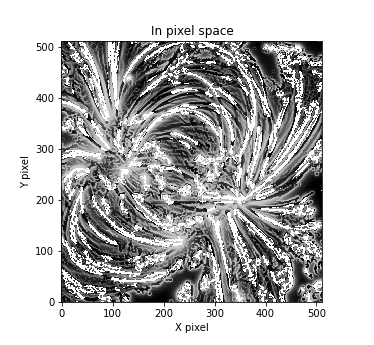
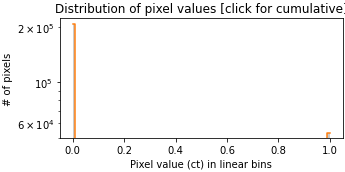
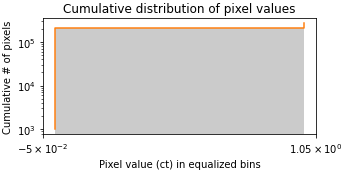

In [91]:
nsm = 9  # Smoothing factor
from scipy.ndimage import gaussian_filter

processed_data = np.copy(solar_map.data)
processed_data[processed_data < solar_map.data.mean()/3] = 0


plot_img(hessian(gaussian(processed_data)))